### test baseline with onehot using machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

import sys 
sys.path.append("..") 
from src import fasta2onehot

In [2]:
# 1 prepare datasets
train_df = pd.read_pickle('../datasets/middlefile/train_stab_df.pkl')
test_df = pd.read_pickle('../datasets/middlefile/test_stab_df.pkl')
print(train_df.shape)
train_df.head()

(187, 8)


,pdb_id,pdb_chain,uniprot_id,mutation,shifted_mutation,ddg,seq_before,seq_after
0,1PY6,A,space,E9A,E5A,-0.1,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPAWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...
1,1PY6,A,space,L13A,L9A,-1.8,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWAALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...
2,1PY6,A,space,A39P,A35P,-0.6,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDPKKFYAITTLVP...
3,1PY6,A,space,F42A,F38A,-2.0,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKAYAITTLVP...
4,1PY6,A,space,Y43A,Y39A,-2.1,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVP...,TGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFAAITTLVP...


In [3]:
from sklearn.utils import shuffle
shuffled = shuffle(train_df)

maxlen = 512
seq_feature = []
fastatool = fasta2onehot.fasta2onehot()
for i in range(shuffled.shape[0]):
    seq_before = fastatool.convert(shuffled['seq_before'][i], maxlen).flatten().tolist()
    seq_after = fastatool.convert(shuffled['seq_after'][i], maxlen).flatten().tolist()
    seq_feature.append(seq_before + seq_after)

X = np.array(seq_feature)
Y = shuffled['ddg'].values
print(X.shape)
print(Y.shape)

(187, 20480)
(187,)


In [4]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
sns.set(color_codes=True)

cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = XGBRegressor(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict(test_x)
    cv_result.append(result)
    cv_label.append(test_y)

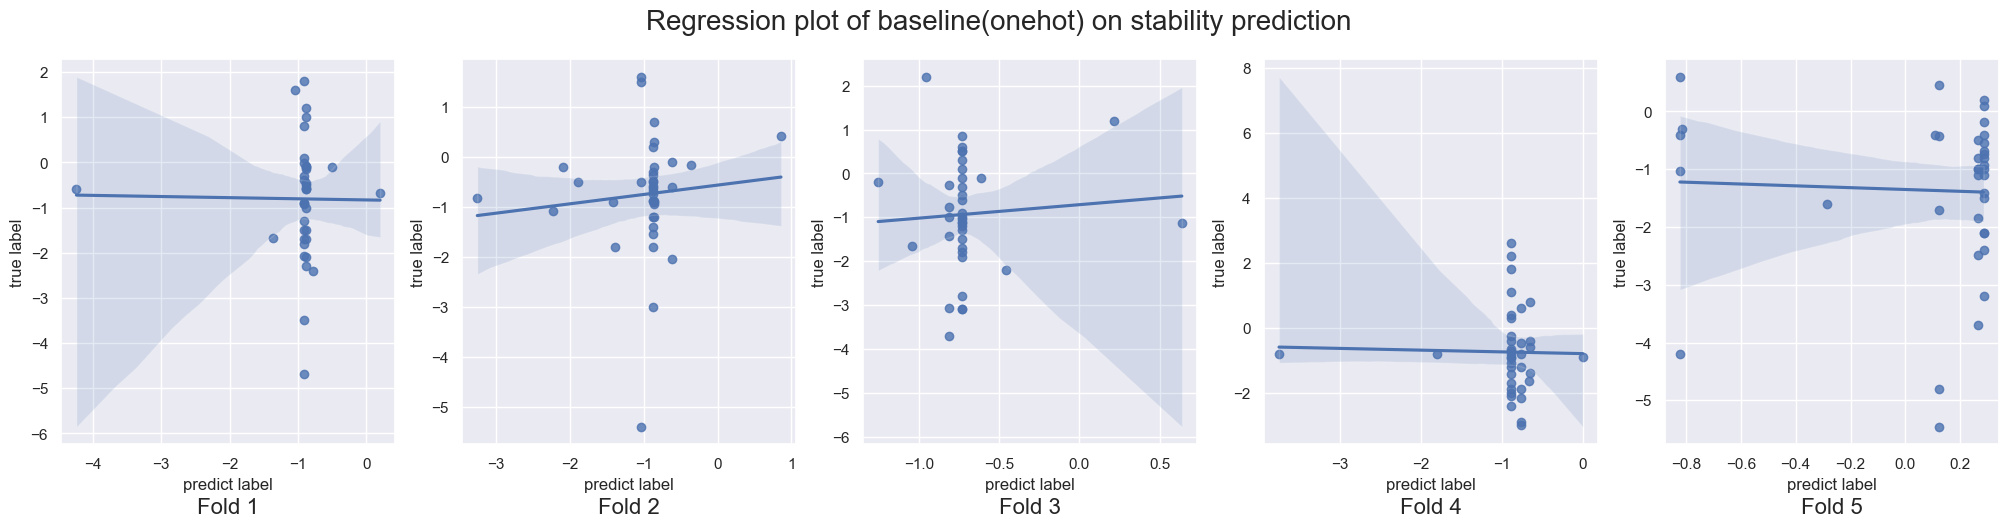

In [5]:
fig = plt.figure(figsize=(25,5))
rmse_list = []
r2_list = []
pcc_list = []
for i in range(5):
    rmse_list.append(mean_squared_error(cv_label[i], cv_result[i]))
    r2_list.append(r2_score(cv_label[i], cv_result[i]))
    pcc_list.append(pearsonr(cv_label[i], cv_result[i])[0])
    plt.subplot(1, 5, i+1)
    plt.title('Fold ' + str(i+1), fontsize=16,y=-0.2)
    plt.ylabel("true label")
    plt.xlabel("predict label")
    sns.regplot(x=cv_result[i],y=cv_label[i])

plt.suptitle('Regression plot of baseline(onehot) on stability prediction', fontsize=20)
plt.savefig('images/stab-ML-onehot/onehot-stab.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [6]:
print('5-fold training avg rmse=', np.average(np.array(rmse_list)))
print('5-fold avg training r-square=', np.average(np.array(r2_list)))
print('5-fold avg training pearson-cc=',np.average(np.array(pcc_list)))

5-fold training avg rmse= 2.302769265842179
5-fold avg training r-square= -0.37855327602064437
5-fold avg training pearson-cc= 0.018613920221999473
